In [ ]:

#!pip install -r requirements.txt

In [ ]:
#!pip install pytorch_lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/3D/train_update.csv")

In [ ]:
train_df.head()

,Unnamed: 0,img_path,printer_id,print_id,has_under_extrusion,img_path_resized
0,0,/content/images/101/1678589738/1678589914.0603...,101,1678589738,1,/content/drive/MyDrive/3D/images_resized_224/1...
1,1,/content/images/101/1678589738/1678589914.4628...,101,1678589738,1,/content/drive/MyDrive/3D/images_resized_224/1...
2,2,/content/images/101/1678589738/1678589914.8750...,101,1678589738,1,/content/drive/MyDrive/3D/images_resized_224/1...
3,3,/content/images/101/1678589738/1678589915.2844...,101,1678589738,1,/content/drive/MyDrive/3D/images_resized_224/1...
4,4,/content/images/101/1678589738/1678589915.7004...,101,1678589738,1,/content/drive/MyDrive/3D/images_resized_224/1...


In [ ]:
train_df["has_under_extrusion"] = train_df["has_under_extrusion"].apply(str)
train_df["print_id"] = train_df["print_id"].apply(str)
train_df["printer_id"] = train_df["printer_id"].apply(str)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

In [ ]:
input_dir = "/content/drive/MyDrive/3D/images_resized_224"
batch_size = 512
img_height = 224
img_width = 224

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  #To prevent overfitting of the model
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest",
    validation_split=0.2  # Split the data into 80% training and 20% validation
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  #As the image path are in csv we set this to NULL
    x_col='img_path_resized',
    y_col='has_under_extrusion',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle = True
)

Found 64848 validated image filenames belonging to 2 classes.


In [ ]:

val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='img_path_resized',
    y_col='has_under_extrusion',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle = True
)

Found 16212 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:

from tensorflow.keras.models import Model
import keras

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape = (img_height,img_width,3))
vgg16.trainable = False

#train_df = preprocess_input(train_df) 
#test_ds = preprocess_input(test_ds)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
output = vgg16.layers[-1].output
output = keras.layers.Flatten()(output)

In [ ]:
vgg16 = Model(vgg16.input,output)

In [ ]:
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(vgg16)
model.add(Dense(128,activation='relu',input_dim = (img_height,img_width,3)))
model.add(Dropout(0.5)),
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

In [ ]:
from keras import optimizers
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks = [early_stop])

Epoch 1/100
127/127 [==============================] - 18543s 146s/step - loss: 0.5465 - accuracy: 0.7193 - val_loss: 1.0495 - val_accuracy: 0.7198
Epoch 2/100
127/127 [==============================] - 2643s 21s/step - loss: 0.3538 - accuracy: 0.8496 - val_loss: 1.4238 - val_accuracy: 0.7101
Epoch 3/100
127/127 [==============================] - 2658s 21s/step - loss: 0.2803 - accuracy: 0.8864 - val_loss: 1.3524 - val_accuracy: 0.7408
Epoch 4/100
127/127 [==============================] - 2658s 21s/step - loss: 0.2384 - accuracy: 0.9032 - val_loss: 1.5971 - val_accuracy: 0.7268


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/3D/test.csv")

In [ ]:
test.head()

,img_path,printer_id,print_id
0,/content/drive/MyDrive/3D/images_resized_224/1...,101,1678578332
1,/content/drive/MyDrive/3D/images_resized_224/1...,101,1678578332
2,/content/drive/MyDrive/3D/images_resized_224/1...,101,1678578332
3,/content/drive/MyDrive/3D/images_resized_224/1...,101,1678578332
4,/content/drive/MyDrive/3D/images_resized_224/1...,101,1678578332


In [ ]:
test['img_path'] = "/content/drive/MyDrive/3D/images_resized_224/" + test['img_path']

In [ ]:
prediction = []
from PIL import Image
for index, row in test.iterrows():
    # Load the image and preprocess it
    img = Image.open(row['img_path'])
    img = np.array(img) / 255.0  # Normalize the pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add a batch dimension

    # Get the predicted class probabilities
    probs = model.predict(img)
    result = np.argmax(probs)
    prediction.append(result)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 63ms/step


In [ ]:
model.save('/content/drive/MyDrive/3D/best_model.h5')

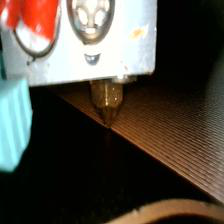

In [ ]:
# importing modules
import urllib.request
from PIL import Image



img = Image.open('/content/drive/MyDrive/3D/images_resized_224/021/1673046546/1673047231.351966.jpg')
img.show()


In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/3D/sample_submission.csv")

In [ ]:
submit['has_under_extrusion'] = prediction 
submit.to_csv('/content/drive/MyDrive/3D/submission1.csv')